In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import sys

from pathlib import Path

import numpy as np
import pandas as pd

from river import metrics
from river import utils, compose
from river.proba import Gaussian
from scipy.stats import kstest

sys.path.insert(1, str(Path().resolve().parent))
from functions.anomaly import (GaussianScorer, ConditionalGaussianScorer,
                               ThresholdChangeFilter)
from functions.proba import MultivariateGaussian
from functions.plot import plot_limits_3d, plot_limits_grid

from models.bess_model import BESS

from publications.ilustrate.pc2023.plot_matplotlib import *

In [3]:
df = pd.read_csv("data/data_BESS_ESwA23.csv", index_col=0)
df = df.loc['2022-03-05':'2022-03-14']
df.index = pd.to_datetime(df.index, utc=True)
df['Power Setpoint Deviation'] = df['String Power'] - df['Active Power Setpoint']

In [4]:
# CONSTANTS
days = 4
WINDOW = dt.timedelta(days=days)
minutes = int(WINDOW.total_seconds()/60)
GRACE_PERIOD=int(minutes/4)
THRESHOLD = 0.9995

blacklist = [
    "String Power",
    "Active Power Setpoint",
    "Ambient Temperature",
    "SOC",
    "Battery part Fan Vb1 Feedback",
    "HVAC Battery part Circulation Fan V1",
    "HVAC Battery part cooling",
    "HVAC Battery part heating",
    "Max. Cell Temperatue",
    "Min. Cell Temperature",
    # "Avg. Cell Temperature",
    'Power Setpoint Deviation'
]

model = BESS()
model |= compose.Discard(*blacklist)
model |= (
        ConditionalGaussianScorer(
            # utils.TimeRolling(MultivariateGaussian(), period=WINDOW),
            utils.Rolling(MultivariateGaussian(), window_size=minutes),
            grace_period=GRACE_PERIOD,
            t_a = 60*3,
            threshold=THRESHOLD
            )
    )

sampling_model = GaussianScorer(Gaussian()._from_state(minutes, 60, 60**2, 1), grace_period=GRACE_PERIOD)

system_anomaly = []
signal_anomaly = []
sampling_anomaly = []
change_point = []
list_thresh_pos = []
list_thresh_neg = []
mus = []
covars = []
sigmas = []
samples = []
scores = []
d = []

for i, (t, x) in enumerate(df.iterrows()):
    t = t.tz_localize(None)
    x = x.to_dict()
    x_ = model.transform_one(x)
    d.append(x_['Diff Cell Temperature'])
    # Check anomaly in system
    is_anomaly = model.predict_one(x); system_anomaly.append(is_anomaly)
    score = model.score_one(x); scores.append(score)
    # Get signal thresholds
    thresh_high, thresh_low = model["ConditionalGaussianScorer"].limit_one(x_)
    list_thresh_pos.append(thresh_high)
    list_thresh_neg.append(thresh_low)
    # Check anomaly in signals
    if i > GRACE_PERIOD:
        signal_anomaly.append({k: not ((thresh_low[k] < v) and
                                       (v < thresh_high[k])) 
                               for i, (k, v) in enumerate(x_.items())})
    else:
        signal_anomaly.append({k: False for i, (k, v) in enumerate(x_.items())})
    # Check anomaly in sampling
    if i > GRACE_PERIOD:
        score_ = sampling_model.score_one((t-t_prev).seconds)
        if sampling_model.gaussian.n_samples > sampling_model.grace_period:
            sample_a = 1 if ((1-THRESHOLD) > score_) or (score_ > THRESHOLD) else 0
        else: 
            sample_a = 0
        if sample_a:
            sampling_anomaly.append(1)
            w = 1-score_
        else:
            sampling_anomaly.append(0)
            w = 1
        sampling_model.learn_one((t-t_prev).seconds, w=w)
    else:
        sampling_anomaly.append(0)
    t_prev = t
    
    mus.append(model["ConditionalGaussianScorer"].gaussian.mu)
    covars.append(model["ConditionalGaussianScorer"].gaussian.var)
    sigmas.append(model["ConditionalGaussianScorer"].gaussian.sigma)
    samples.append(model["ConditionalGaussianScorer"].gaussian.n_samples)
    change_point.append(model["ConditionalGaussianScorer"]._drift_detected())

    model = model.learn_one(x)#, **{'t': t})

for i in range(len(sampling_anomaly)):
    if sampling_anomaly[i] == 1:
        sampling_anomaly[i-1] = 1

df['Diff Cell Temperature'] = d

df_stats = pd.DataFrame({"mus": mus,
                       "covars": covars,
                       "sigmas": sigmas},
                      index= df.index)

df_out = pd.DataFrame({"level_high": list_thresh_pos,
                       "level_low": list_thresh_neg,
                       "System Anomaly": system_anomaly,
                       "Signal Anomaly": signal_anomaly,
                       "Sampling Anomaly": sampling_anomaly,
                       "Changepoint": change_point,
                       "scores": scores},
                      index= df.index)

In [5]:
events_count = sum(pd.Series(system_anomaly).diff().dropna() == 1)
text = (
    f"Sliding window: {WINDOW}\n"
    f"Proportion of anomalous samples: "
    f"{sum(system_anomaly)/len(system_anomaly)*100:.02f}%\n"
    f"Anomaly every: "
    f"{len(system_anomaly)/sum(system_anomaly):.00f} samples\n"
    f"Total number of anomalous events: "
    f"{events_count}\n"
    f"Anomalous event every: "
    f"{len(system_anomaly)/events_count:.00f} samples\n"
    f"Total number of change points: "
    f"{sum(pd.Series(change_point).diff().dropna() == 1)}\n"
    f"Total number of sampling anomalies: "
    f"{sum(pd.Series(sampling_anomaly).diff().dropna() == 1)}"
    )

print(text)

Sliding window: 4 days, 0:00:00
Proportion of anomalous samples: 6.16%
Anomaly every: 16 samples
Total number of anomalous events: 14
Anomalous event every: 893 samples
Total number of change points: 1
Total number of sampling anomalies: 3


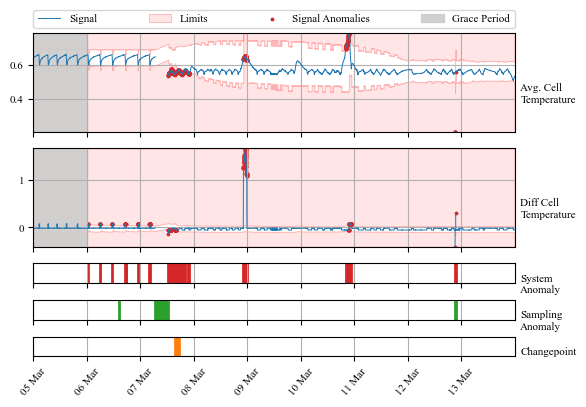

In [6]:
plot_limits_grid_(
    df.drop(columns=blacklist),
    df_out["Changepoint"], 
    df_out["Sampling Anomaly"],
    df_out['System Anomaly'],
    ser_high=df_out.iloc[1:, :]['level_high'],
    ser_low=df_out.iloc[1:, :]['level_low'],
    signal_anomaly=df_out["Signal Anomaly"],
    file_name="TERRA",
    save=True,
    **{
        'resample': '1t',
        'grace_period': GRACE_PERIOD
        })